Preparing monthly data...
Data range: 2012-09-01 00:00:00 to 2014-08-01 00:00:00
Total months: 24

Decomposing time series...

Finding optimal parameters...
Finding optimal SARIMA parameters...
SARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:345.3478817679011
SARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:87.57258010252654
SARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:71.59641456921214
SARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:4.0
SARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:93.00025825033866
SARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:75.13024639253084
SARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:4.0
SARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:6.0
SARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:316.0259377017921
SARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:70.20234692728113
SARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:59.035913094664146
SARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:6.0
SARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:91.79830527560414
SARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:58.29791968379218
SARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:6.0
SARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:8.0
SARIMA(0, 0, 2)x(0, 0, 0,

<Figure size 1400x600 with 0 Axes>

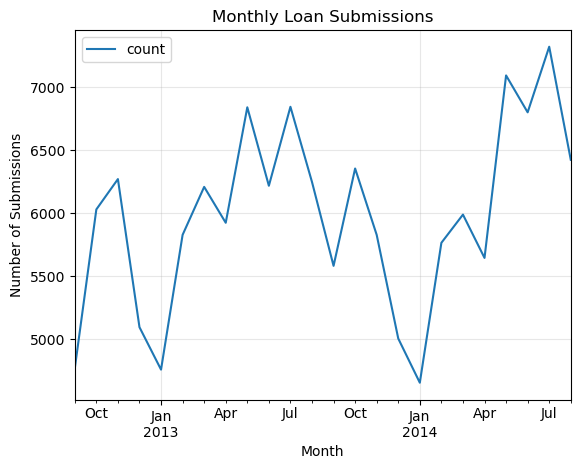

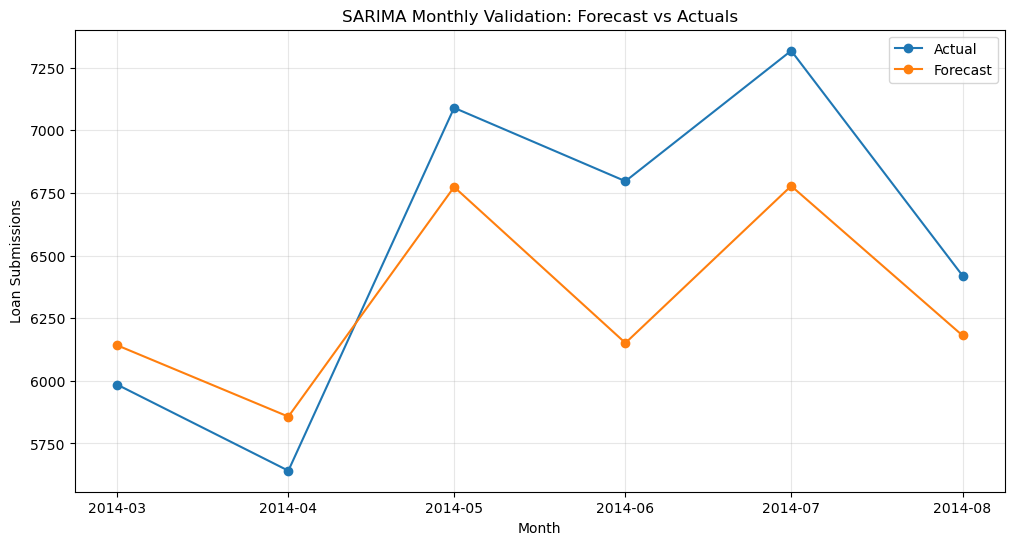

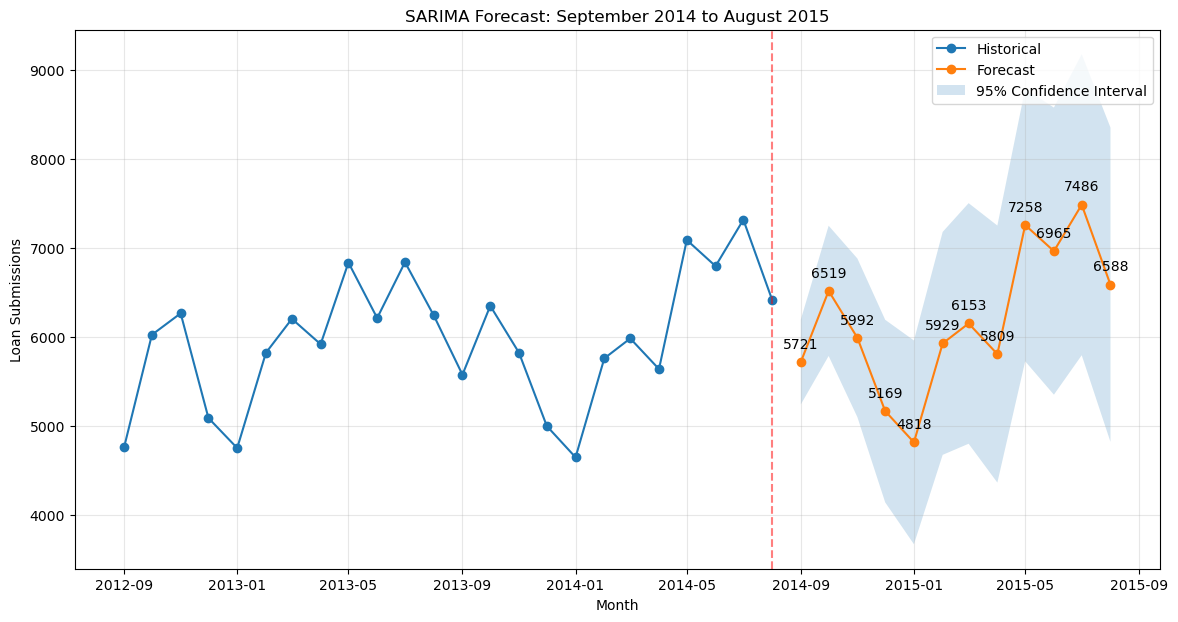

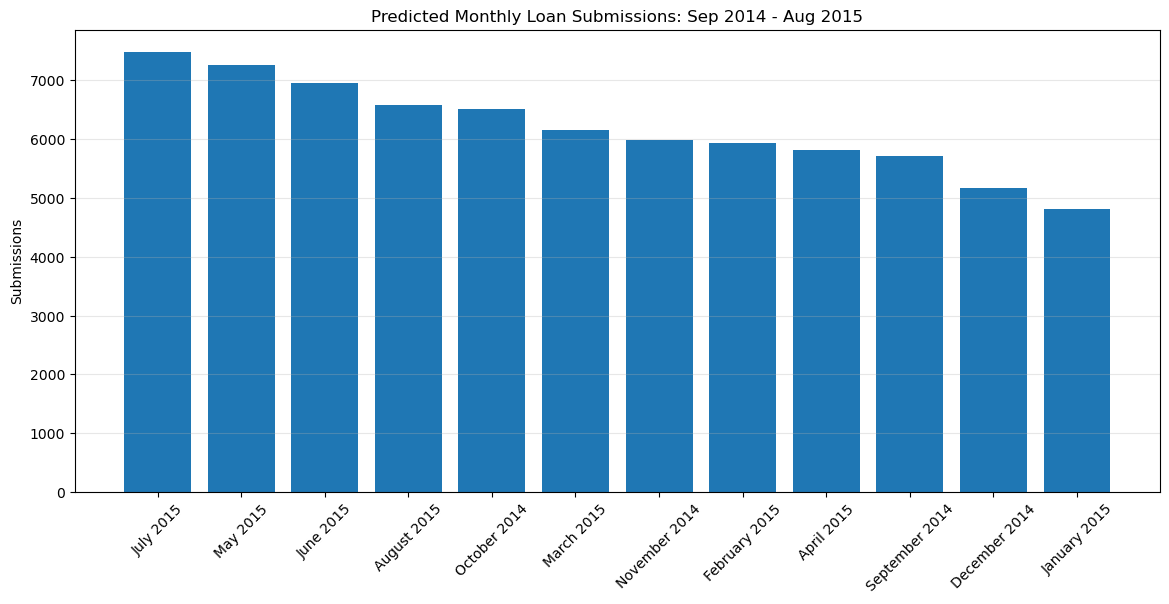

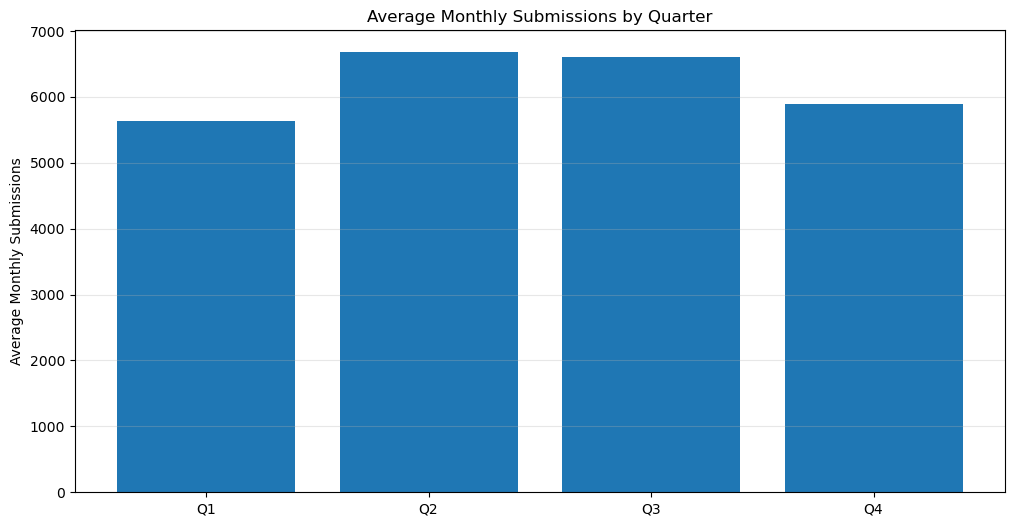

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

def prepare_monthly_data(file_path):
    df = pd.read_excel(file_path)
    
    df['DT_DateSubmitted'] = pd.to_datetime(df['DT_DateSubmitted'])
    
    df['YearMonth'] = df['DT_DateSubmitted'].dt.to_period('M')
    
    monthly_counts = df.groupby('YearMonth').size().reset_index(name='count')
    
    monthly_counts['YearMonth'] = monthly_counts['YearMonth'].dt.to_timestamp()
    
    monthly_counts.set_index('YearMonth', inplace=True)
    
    monthly_counts = monthly_counts.asfreq('MS')
    
    print(f"Data range: {monthly_counts.index.min()} to {monthly_counts.index.max()}")
    print(f"Total months: {len(monthly_counts)}")
    
    return monthly_counts

def decompose_time_series(series, period=12):
    decomposition = seasonal_decompose(series, model='additive', period=period)
    
    return decomposition

def find_optimal_sarima_params(series, validation_size=6):
    train = series[:-validation_size]
    valid = series[-validation_size:]
    
    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(range(0, 2), range(0, 2), range(0, 2)))]
    
    best_aic = float("inf")
    best_params = None
    best_seasonal_params = None
    
    print("Finding optimal SARIMA parameters...")
    for param in pdq:
        for seasonal_param in seasonal_pdq:
            try:
                model = SARIMAX(train,
                               order=param,
                               seasonal_order=seasonal_param,
                               enforce_stationarity=False,
                               enforce_invertibility=False)
                results = model.fit(disp=False)
                
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_params = param
                    best_seasonal_params = seasonal_param
                    
                print(f'SARIMA{param}x{seasonal_param} - AIC:{results.aic}')
            except:
                continue
    
    print(f'\nBest SARIMA Parameters: SARIMA{best_params}x{best_seasonal_params}')
    return best_params, best_seasonal_params

def validate_sarima_model(series, order, seasonal_order, validation_size=6):
    train = series[:-validation_size]
    valid = series[-validation_size:]
    
    model = SARIMAX(train,
                   order=order,
                   seasonal_order=seasonal_order,
                   enforce_stationarity=False,
                   enforce_invertibility=False)
    results = model.fit(disp=False)
    
    forecast = results.get_forecast(steps=validation_size)
    forecast_mean = forecast.predicted_mean
    
    valid_array = valid.values.flatten()
    forecast_array = forecast_mean.values
    
    mape = mean_absolute_percentage_error(valid_array, forecast_array) * 100
    mae = mean_absolute_error(valid_array, forecast_array)
    rmse = np.sqrt(mean_squared_error(valid_array, forecast_array))
    
    print(f"Validation Metrics:")
    print(f"MAPE: {mape:.2f}%")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(valid.index, valid_array, 'o-', label='Actual')
    plt.plot(valid.index, forecast_array, 'o-', label='Forecast')
    plt.fill_between(valid.index, 
                    forecast.conf_int().iloc[:, 0], 
                    forecast.conf_int().iloc[:, 1], 
                    alpha=0.2)
    plt.title('SARIMA Monthly Validation: Forecast vs Actuals')
    plt.xlabel('Month')
    plt.ylabel('Loan Submissions')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    return results, mape, mae, rmse

def generate_sarima_forecast(series, order, seasonal_order, forecast_start='2014-09-01', forecast_end='2015-08-01'):
    model = SARIMAX(series,
                   order=order,
                   seasonal_order=seasonal_order,
                   enforce_stationarity=False,
                   enforce_invertibility=False)
    results = model.fit(disp=False)
    
    forecast_start_date = pd.to_datetime(forecast_start)
    forecast_end_date = pd.to_datetime(forecast_end)
    forecast_periods = (forecast_end_date.year - forecast_start_date.year) * 12 + forecast_end_date.month - forecast_start_date.month + 1
    
    forecast = results.get_forecast(steps=forecast_periods)
    forecast_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()
    
    forecast_df = pd.DataFrame({
        'ds': forecast_mean.index,
        'yhat': forecast_mean.values,
        'yhat_lower': conf_int.iloc[:, 0].values,
        'yhat_upper': conf_int.iloc[:, 1].values
    })
    
    plt.figure(figsize=(14, 7))
    
    plt.plot(series.index, series.values, 'o-', label='Historical')
    
    plt.plot(forecast_df['ds'], forecast_df['yhat'], 'o-', label='Forecast')
    plt.fill_between(forecast_df['ds'], 
                    forecast_df['yhat_lower'],
                    forecast_df['yhat_upper'],
                    alpha=0.2,
                    label='95% Confidence Interval')
    
    plt.axvline(x=series.index[-1], color='r', linestyle='--', alpha=0.5)
    
    plt.title('SARIMA Forecast: September 2014 to August 2015')
    plt.xlabel('Month')
    plt.ylabel('Loan Submissions')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    for i, (date, value) in enumerate(zip(forecast_df['ds'], forecast_df['yhat'])):
        plt.annotate(f'{value:.0f}', 
                    (date, value), 
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center')
    
    return results, forecast_df

def generate_monthly_insights(forecast_df):
    forecast_df['ds'] = pd.to_datetime(forecast_df['ds'])
    
    forecast_df['month'] = forecast_df['ds'].dt.month
    forecast_df['month_name'] = forecast_df['ds'].dt.strftime('%B')
    forecast_df['quarter'] = forecast_df['ds'].dt.quarter
    
    monthly_data = forecast_df.sort_values('yhat', ascending=False).reset_index(drop=True)
    
    quarterly_avg = forecast_df.groupby('quarter')['yhat'].mean().reset_index()
    
    print("\nForecast Insights:")
    print("\nMonthly Loan Submissions (Ranked by Volume):")
    for i, row in monthly_data.iterrows():
        print(f"  {row['month_name']} {row['ds'].year}: {row['yhat']:.0f} submissions (predicted)")
    
    print("\nQuarterly Average Submissions:")
    for _, row in quarterly_avg.iterrows():
        print(f"  Q{row['quarter']}: {row['yhat']:.0f} average monthly submissions")
        
    plt.figure(figsize=(14, 6))
    plt.bar(monthly_data['month_name'] + ' ' + monthly_data['ds'].dt.year.astype(str), 
            monthly_data['yhat'])
    plt.title('Predicted Monthly Loan Submissions: Sep 2014 - Aug 2015')
    plt.ylabel('Submissions')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.figure(figsize=(12, 6))
    plt.bar([f"Q{q}" for q in quarterly_avg['quarter']], quarterly_avg['yhat'])
    plt.title('Average Monthly Submissions by Quarter')
    plt.ylabel('Average Monthly Submissions')
    plt.grid(True, alpha=0.3, axis='y')
    
    return monthly_data, quarterly_avg

def run_monthly_sarima_forecast(file_path):
    print("Preparing monthly data...")
    monthly_series = prepare_monthly_data(file_path)
    
    plt.figure(figsize=(14, 6))
    monthly_series.plot()
    plt.title('Monthly Loan Submissions')
    plt.xlabel('Month')
    plt.ylabel('Number of Submissions')
    plt.grid(True, alpha=0.3)
    
    print("\nDecomposing time series...")
    decomposition = decompose_time_series(monthly_series['count'])
    
    print("\nFinding optimal parameters...")
    order, seasonal_order = find_optimal_sarima_params(monthly_series['count'])
    
    print("\nValidating model...")
    results, mape, mae, rmse = validate_sarima_model(monthly_series['count'], order, seasonal_order)
    
    print("\nGenerating forecast for Sep 2014 to Aug 2015...")
    _, forecast_df = generate_sarima_forecast(monthly_series['count'], order, seasonal_order)
    
    print("\nExtracting insights...")
    monthly_data, quarterly_avg = generate_monthly_insights(forecast_df)
      
    return results, forecast_df, order, seasonal_order

if __name__ == "__main__":
    results, forecast_df, order, seasonal_order = run_monthly_sarima_forecast('daily.xlsx')
    
    plt.show()